# 批量归一化

从零实现

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过 `is_grad_enabled` 来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

## 创建一个正确的 BatchNorm 图层

In [6]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,
            eps=1e-5, momentum=0.9)
        return Y

## 应用BatchNorm 于LeNet模型

In [7]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16,
                              kernel_size=5), BatchNorm(16, num_dims=4),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
                    BatchNorm(120, num_dims=2), nn.Sigmoid(),
                    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                    nn.Sigmoid(), nn.Linear(84, 10))


## 在Fashion-MNIST数据集上训练网络

loss 0.253, train acc 0.907, test acc 0.885
11178.4 examples/sec on cpu


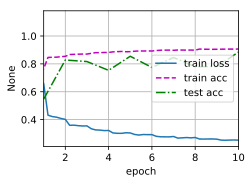

In [10]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 拉伸参数 gamma 和偏移参数 beta

In [11]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7671, 1.5184, 1.4832, 2.3768, 2.2349, 1.6075],
        grad_fn=<ViewBackward>),
 tensor([ 0.0306, -0.5868, -1.0885,  1.1981,  2.0797, -1.7459],
        grad_fn=<ViewBackward>))

# 简明实现

In [12]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
                    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Flatten(), nn.Linear(256, 120), nn.BatchNorm1d(120),
                    nn.Sigmoid(), nn.Linear(120, 84), nn.BatchNorm1d(84),
                    nn.Sigmoid(), nn.Linear(84, 10))

## 使用相同超参数来训练模型

loss 0.247, train acc 0.910, test acc 0.865
15692.1 examples/sec on cpu


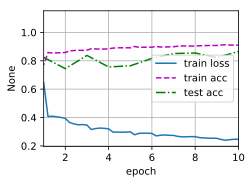

In [13]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
